In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
import crocosi.gridop as grd
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.0.32:51157 Dashboard: http://10.148.0.32:8787/status,Cluster Workers: 21 Cores: 21 Memory: 359.94 GB


In [2]:
data = np.random.rand(20,10, 5)
time = np.linspace(0,20,20)
x = np.linspace(0,5,5)
y = np.linspace(0,10,10)

In [3]:
foo = xr.DataArray(data, coords=[time, y, x], dims=["time", "ygrid",'xgrid'])

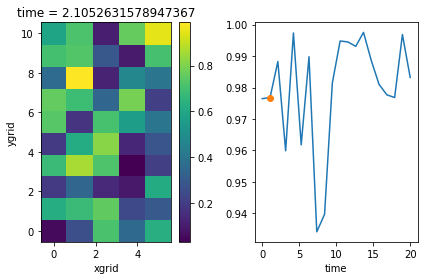

In [4]:
fig,ax = plt.subplots(1,2)
foo.isel(time=2).plot(ax=ax[0])
foo.max(['xgrid','ygrid']).plot(ax=ax[1])
ax[1].plot(time[1],foo.max(['xgrid','ygrid']).isel(time=1),'o')
fig.tight_layout()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


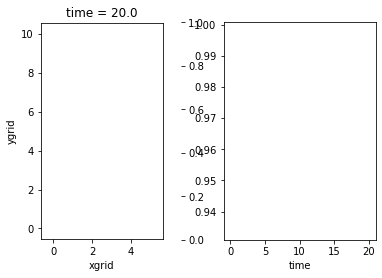

In [19]:
from celluloid import Camera
fig,axes = plt.subplots(1,2)
camera = Camera(fig)
im=foo.isel(time=0).plot(ax=axes[0],vmin=0,vmax=1,add_colorbar=True)#plt.plot(t, np.sin(t + i), color='blue')
foo.max(['xgrid','ygrid']).plot.line('b',ax=axes[1])
axes[1].plot(time[0],foo.max(['xgrid','ygrid']).isel(time=0), 'ro')
camera.snap()
#t = np.linspace(0, 2 * np.pi, 128, endpoint=False)
for i in range(time.size):
    im=foo.isel(time=i).plot(ax=axes[0],vmin=0,vmax=1,add_colorbar=False)#plt.plot(t, np.sin(t + i), color='blue')
    axes[0].set_aspect('equal')
    foo.max(['xgrid','ygrid']).plot.line('b',ax=axes[1])
    axes[1].plot(time[i],foo.max(['xgrid','ygrid']).isel(time=i), 'ro')
    im.set_clim(0,1)
    #plt.colorbar(im, ax=axes[0])
    #axes[1].plot(t, np.sin(t - i), color='blue')
    camera.snap()
animation = camera.animate()
animation.save('/home1/datawork/zcaspar/tst.gif', writer = 'imagemagick')


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


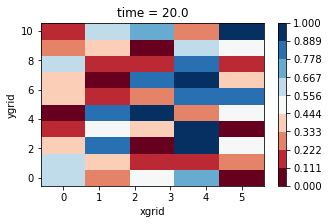

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(0, 5), ylim=(0, 10))

contour_opts = {'levels': np.linspace(0, 1, 10),
                'cmap':'RdBu'}
cax = foo.isel(time=0).plot(ax=ax,**contour_opts)
 
def animate(i):
    ax.collections = []
    foo.isel(time=i-1).plot(add_colorbar=False,**contour_opts)

anim = FuncAnimation(fig, animate,frames=19)

anim.save('/home1/datawork/zcaspar/tst.gif', writer = 'imagemagick')
plt.draw()
plt.show()



In [5]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [7]:
V = ['u', 'v']
dij = 1
dti = 6
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 18 GB


In [8]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 12000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    f_rho         (y_rho) float32 7.96396e-05 7.97044e-05 ... 0.00012636039
    s_rho_slice0  float32 -0.01
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
  * time          (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    f             (y_rho) float32 7.96396e-05 7.97044e-05 ... 0.00012636039
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(1200, 722, 257), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(1200, 721, 258), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [12]:
from collections import OrderedDict
def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [18]:
vtst = x2rho(ds['v'].isel(time=500),r.xgrid,'extrapolate').compute()
utst = x2rho(ds['u'].isel(time=500),r.xgrid,'extrapolate').compute()

[Text(0, 0, '0.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '400.0'),
 Text(0, 0, '600.0'),
 Text(0, 0, '800.0'),
 Text(0, 0, '1000.0'),
 Text(0, 0, '1200.0')]

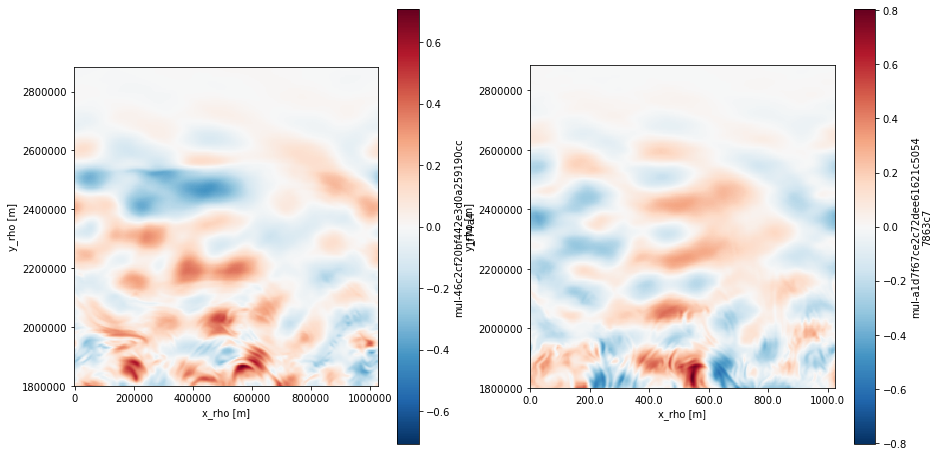

In [50]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
vtst.sel(y_rho=slice(1800*1e3,None)).plot(ax=ax[1]);ax[1].set_aspect('equal')
utst.sel(y_rho=slice(1800*1e3,None)).plot(ax=ax[0]);ax[0].set_aspect('equal')
ax[1].set_xlim(0,1024*1e3)
lab = ax[1].get_xticks()
lab = [str(l*1e-3) for l in lab]
ax[1].set_xticklabels(lab)

In [44]:
ax[1].set_xticklabels(la)

[Text(-200000.0, 0, '-200.0'),
 Text(0.0, 0, '0.0'),
 Text(200000.0, 0, '200.0'),
 Text(400000.0, 0, '400.0'),
 Text(600000.0, 0, '600.0'),
 Text(800000.0, 0, '800.0'),
 Text(1000000.0, 0, '1000.0'),
 Text(1200000.0, 0, '1200.0')]

In [29]:
vtsti = vtst.sel(y_rho=slice(1800*1e3,None))
utsti = utst.sel(y_rho=slice(1800*1e3,None))
Utsti = 0.5*np.sqrt(vtsti**2+utsti**2)

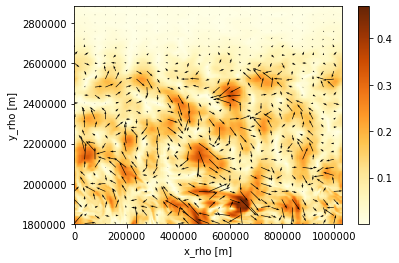

In [47]:
Utsti.plot(cmap='YlOrBr')
plt.quiver(utsti.x_rho[::10],utsti.y_rho[::10],utsti[::10,::10],vtsti[::10,::10])

In [9]:
v = ds['v'].isel(time=slice(0,20*24)).compute()
u = ds['u'].isel(time=slice(0,20*24)).compute()

In [21]:
v.isel(time=slice(0,200*24)).time

<xarray.DataArray 'time' (time: 4800)>
array([1500.00694444, 1500.04861111, 1500.09027778, ..., 1699.88194444,
       1699.92361111, 1699.96527778])
Coordinates:
    s_rho_slice0  float32 -0.01
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.7e+03 1.7e+03
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.7e+03 1.7e+03
Attributes:
    units:          m
    standard_name:  time_instant
    long_name:      time_instant

In [16]:
maps = ['RdBu_r','RdBu_r','YlOrBr']

def gen_figs(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    fig,ax = plt.subplots(1,3,figsize=figsize)
    for V, axs,cmap,names in zip([ui,vi,U],ax,maps,['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$']):
        V.plot(ax=axs,cmap=cmap,cbar_kwargs={'label':names})
        axs.set_xlim(0,1024*1e3);axs.set_ylim(y0*1e3,y1*1e3)
        labx,laby = axs.get_xticks(),axs.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
        axs.set_xticklabels(labx);axs.set_yticklabels(laby)
        axs.set_aspect('equal');axs.set_ylabel(r'$y_\rho$(km)');axs.set_xlabel(r'$x_\rho$(km)')
    ax[2].quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    fig.suptitle('t = %s days'%np.around(v.isel(time=t).time.values,decimals=3),x=0.5,y=1,fontsize=15)
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/North_uv/'+name,overwrite=True)
        plt.close()

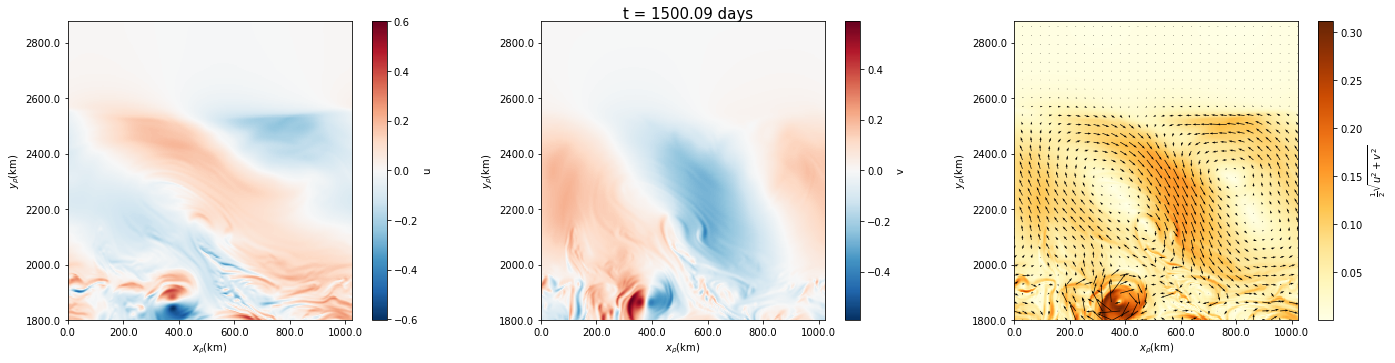

In [17]:
gen_figs(2,1800,2880,8,(20,5),savefig=False,name='test.png')

In [41]:
def gen_figs(t):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(1800*1e3,2880*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(1800*1e3,2880*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
   # fig,ax = plt.subplots(1,3,figsize=figsize)
    for V, axs,cmap,names in zip([ui,vi,U],ax,maps,['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$']):
        V.plot(ax=axs,cmap=cmap,cbar_kwargs={'label':names})
        
        
    ax[2].quiver(ui.x_rho[::8],ui.y_rho[::8],ui[::8,::8],vi[::8,::8])
    fig.suptitle('t = %s days'%np.around(v.isel(time=t).time.values,decimals=3),x=0.5,y=1,fontsize=15)
    fig.tight_layout()
    

Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/matplotlib/animation.py", line 1758, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


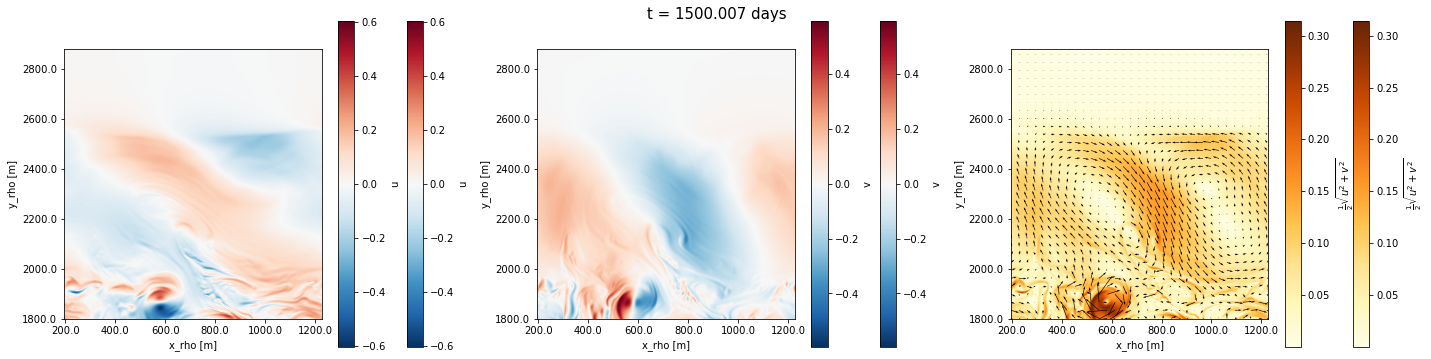

In [44]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
#ax.set(xlim=(0, 1024*), ylim=(0, 10))

#contour_opts = {'levels': np.linspace(0, 1, 10),
#                'cmap':'RdBu'}
from matplotlib.animation import FuncAnimation
cax = gen_figs(0)
for axs in ax:
    axs.set_xlim(0,1024*1e3);axs.set_ylim(1800*1e3,2880*1e3)
    labx,laby = axs.get_xticks(),axs.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    axs.set_xticklabels(labx);axs.set_yticklabels(laby)
    axs.set_aspect('equal');axs.set_ylabel(r'$y_\rho$(km)');axs.set_xlabel(r'$x_\rho$(km)')
def animate(i):
    ax[0].collections = []
    ax[1].collections = []
    ax[2].collections = []
    gen_figs(i)
    
anim = FuncAnimation(fig,gen_figs,frames=20,blit=True)
#anim.save('/home1/datawork/zcaspar/tst.gif', writer = 'imagemagick')
plt.draw()
plt.show()

KeyboardInterrupt: 

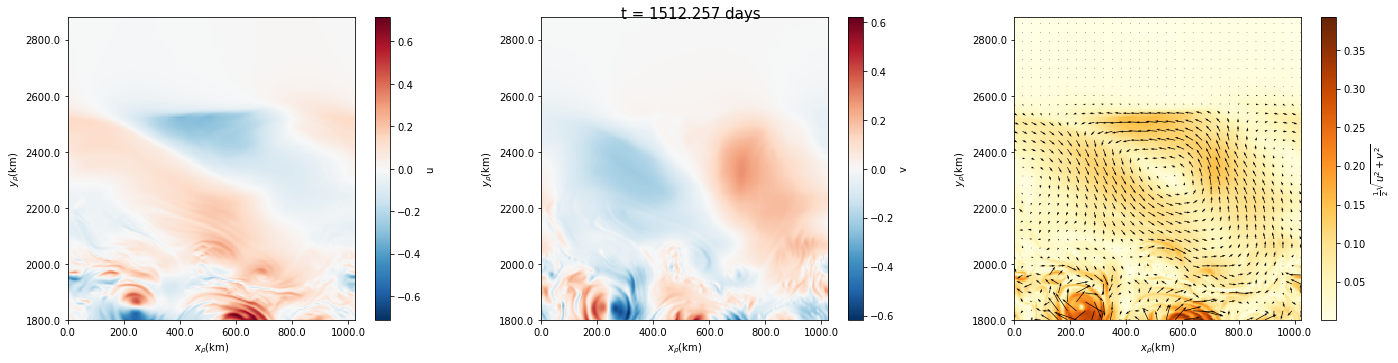

In [28]:
for t in range(v.isel(time=slice(0,200*24)).time.size):
    n='t%s'%t
    gen_figs(t,1800,2880,8,(20,5),savefig=True,name=n+'.png')

In [17]:
def gen_fig(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    fig,ax = plt.subplots(figsize=figsize)
    U.plot(ax=ax,cmap='YlOrBr',vmin=0,vmax=0.5,cbar_kwargs={'label':r'$\frac{1}{2}\sqrt{u^2+v^2}$'})
    ax.set_aspect('equal');ax.set_ylabel(r'$y_\rho$(m)');ax.set_xlabel(r'$x_\rho$(m)')
    ax.quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    plt.title('t = %s days'%np.around(v.isel(time=t).time.values,decimals=2))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/North_uv/'+name,overwrite=True)
        plt.close()

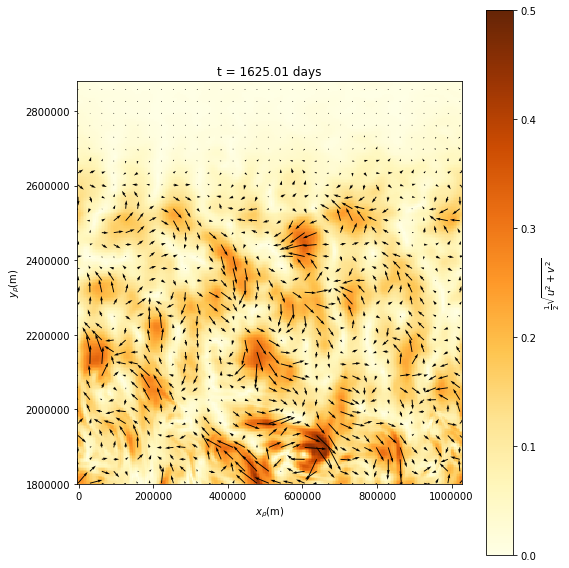

In [48]:
gen_fig(500,1800,2880,8,(8,8))

In [24]:
for t in range(v.isel(time=slice(0,200*24)).time.size):
    n='t%s'%t
    gen_fig(t,1800,2880,8,(7,7),savefig=True,name=n+'.png')

NameError: name 'gen_fig' is not defined

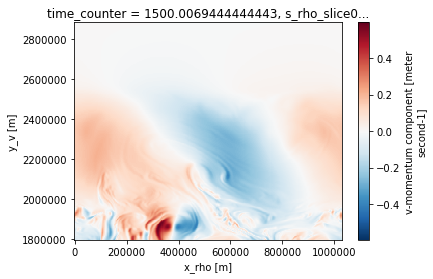

In [14]:
import matplotlib.animation as animation

fig = plt.figure() # initialise la figure
im = v.isel(time=0).sel(y_v=slice(1800*1e3,None)).plot(animated=True)
#plt.xlim(xmin, xmax)
#plt.ylim(-1,1)
i=0
def updatefig(*args):
   # global i
    for i in range(v.isel(time=slice(0,2)).time.size):
        im.set_array(v.isel(time=i).sel(y_v=slice(1800*1e3,None)).values)
    return im,
    #plt.pause(0.01)
#ani = animation.FuncAnimation(fig, updatefig,  blit=True)

# fonction à définir quand blit=True
# crée l'arrière de l'animation qui sera présent sur chaque image
def init():
    line.set_data([],[])
    return line,

def animate(i): 
    t = i * dt
    y = np.cos(k*x - w*t)
    line.set_data(x, y)
    return line,
plt.show()
#ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, blit=True, interval=20, repeat=False)

In [13]:
v.isel(time=i).sel(y_v=slice(1800*1e3,None)).values


array([[-0.137887  , -0.13408142, -0.12118018, ..., -0.13308674,
        -0.137887  , -0.13408142],
       [-0.13515852, -0.12665081, -0.1098358 , ..., -0.13450676,
        -0.13515852, -0.12665081],
       [-0.12659895, -0.11390333, -0.09583312, ..., -0.1308356 ,
        -0.12659895, -0.11390333],
       ...,
       [ 0.00152088,  0.0015115 ,  0.00149654, ...,  0.00152515,
         0.00152088,  0.0015115 ],
       [ 0.00146048,  0.00145136,  0.00143341, ...,  0.00146307,
         0.00146048,  0.00145136],
       [ 0.00140181,  0.00139375,  0.00137469, ...,  0.00140207,
         0.00140181,  0.00139375]], dtype=float32)

In [24]:
fig = plt.figure() # initialise la figure
im = v.isel(time=0).sel(y_v=slice(1800*1e3,None)).plot(animated=True)
im.set_array(v.isel(time=1).sel(y_v=slice(1800*1e3,None)))
plt.show()

ValueError: Collections can only map rank 1 arrays

<Figure size 432x288 with 2 Axes>

In [19]:
im.set_animated(True)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


ValueError: unknown file extension: .mp4

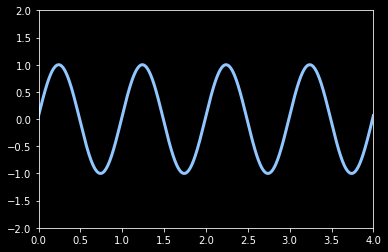

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

anim.save('/home1/datawork/zcaspar/sine_wave.mp4', writer='ffmpeg')

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera

fig, axes = plt.subplots(2)
camera = Camera(fig)
t = np.linspace(0, 2 * np.pi, 128, endpoint=False)
for i in t:
    axes[0].plot(t, np.sin(t + i), color='blue')
    axes[1].plot(t, np.sin(t - i), color='blue')
    camera.snap()
    
animation = camera.animate() 

ModuleNotFoundError: No module named 'celluloid'

In [34]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
